In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [8]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

In [9]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [14]:
load_df = pd.read_csv('Data/DOM/Load Actuals/Processed/Aggregated/load.csv', parse_dates=[0], index_col=0, date_parser=parser)
load_df.head()

,MW
DATE,
2010-01-01 00:00:00,10273.0
2010-01-01 01:00:00,9960.0
2010-01-01 02:00:00,9797.0
2010-01-01 03:00:00,9715.0
2010-01-01 04:00:00,9851.0


In [11]:
context_length = 24*7*4
prediction_length = 24

In [12]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

<AxesSubplot:xlabel='DATE'>

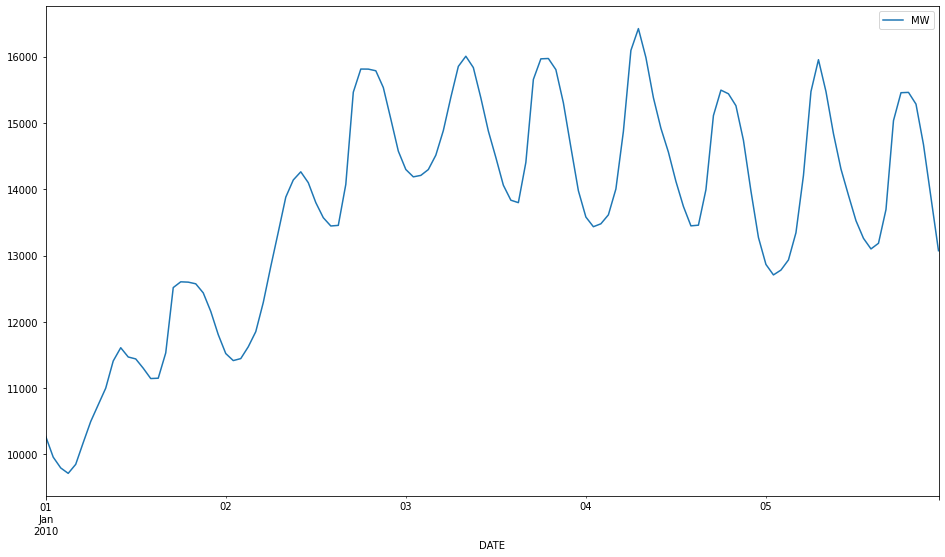

In [38]:
mw = 'MW'

load_df_ex = load_df.loc[:, mw]
load_df.iloc[:24*5].plot()

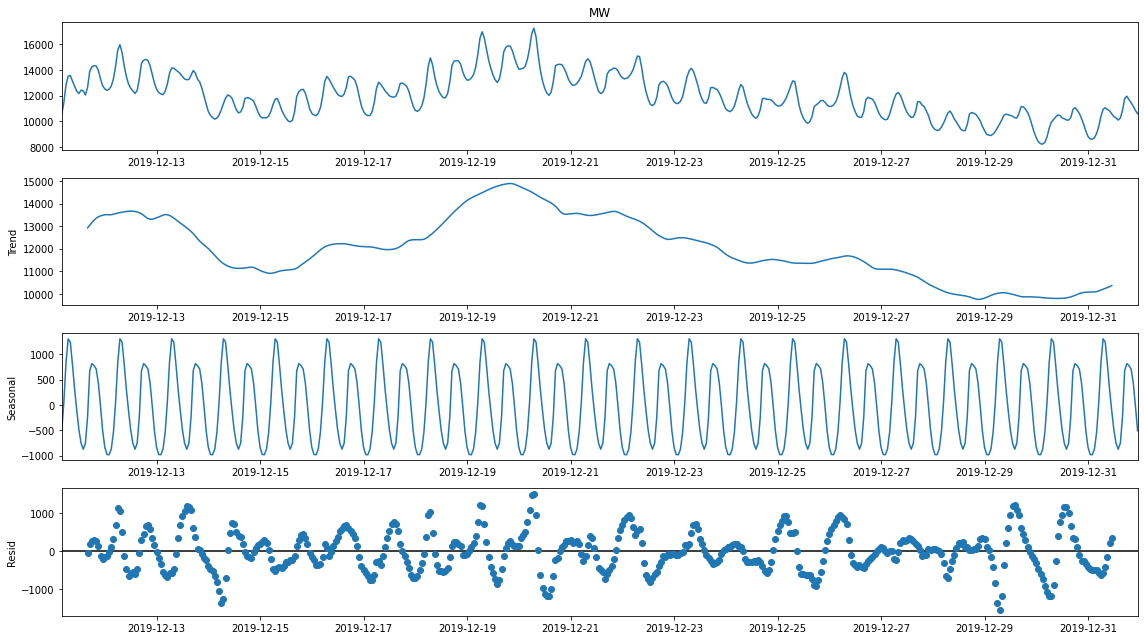

In [16]:
fig = seasonal_decompose(load_df_ex.iloc[-500:], model='additive').plot()

In [22]:
dftest = adfuller(load_df_ex.iloc[-500:], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -1.398207
p-value                          0.583135
#Lags Used                      16.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64

In [24]:
first_diff = load_df_ex.diff()[1:]
dftest = adfuller(first_diff.iloc[-500:], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.488688e+00
p-value                        1.331583e-13
#Lags Used                     1.800000e+01
Number of Observations Used    4.810000e+02
Critical Value (1%)           -3.444018e+00
Critical Value (5%)           -2.867568e+00
Critical Value (10%)          -2.569980e+00
dtype: float64

C:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


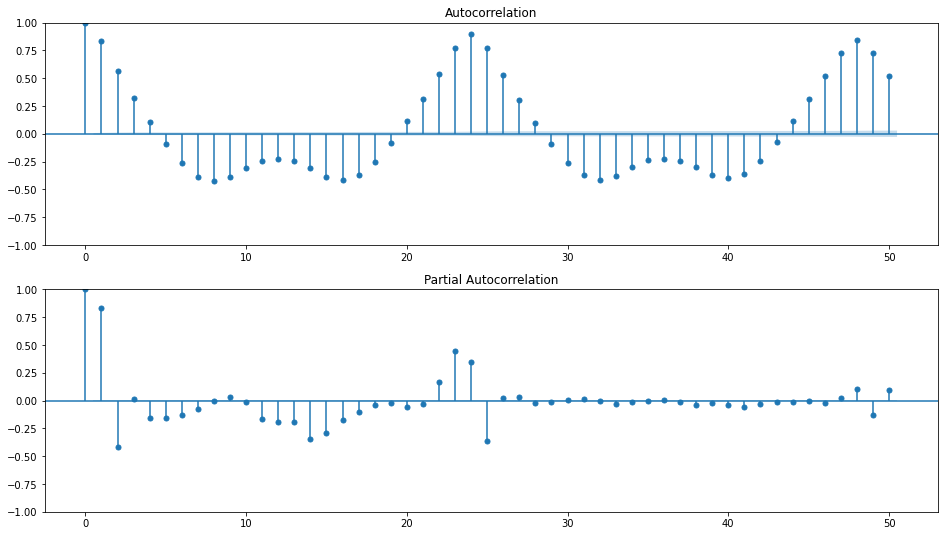

In [25]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(first_diff, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(first_diff, lags=50, ax=ax[1])

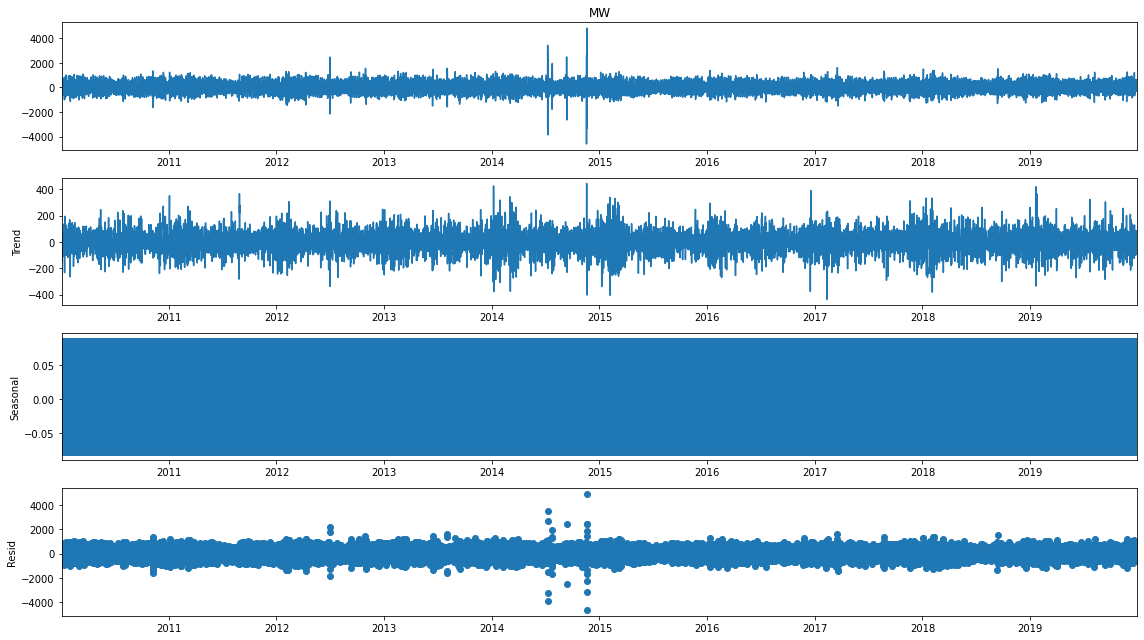

In [27]:
fig = seasonal_decompose(first_diff.diff(24).dropna(), model='additive').plot()

In [28]:
def runSARIMA(time_series, test_length=prediction_length, train_length=context_length):
    ts = time_series.iloc[-(test_length+train_length):]
    ts_train = ts.iloc[:-test_length]
    ts_test = ts.iloc[-test_length:]
    
    sarima = sm.tsa.SARIMAX(ts_train, order=(1,1,1),
                            seasonal_order=(1,1,1,24),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()
    
    summary = sarima.summary()

    fcst = sarima.predict(start=ts_train.index[2], end=ts_test.index[-1])
    first_pred = fcst[0]
    fcst = np.concatenate([np.array([first_pred, first_pred]), fcst])
    fcst = pd.DataFrame(data=fcst, index=ts.index, columns=['pred%s' % ts.name[2:]])
    
    return fcst, summary

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
%%time
fcst, summary = runSARIMA(first_diff)
df_ex = pd.concat([first_diff, fcst], axis=1)
print(summary)

                                     SARIMAX Results                                      
Dep. Variable:                                 MW   No. Observations:                  672
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -3998.650
Date:                            Sat, 09 Apr 2022   AIC                           8007.299
Time:                                    02:15:44   BIC                           8029.456
Sample:                                12-03-2019   HQIC                          8015.911
                                     - 12-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2531      0.093     -2.727      0.006      -0.435      -0.071
ma.L1          0.5367      0.087   

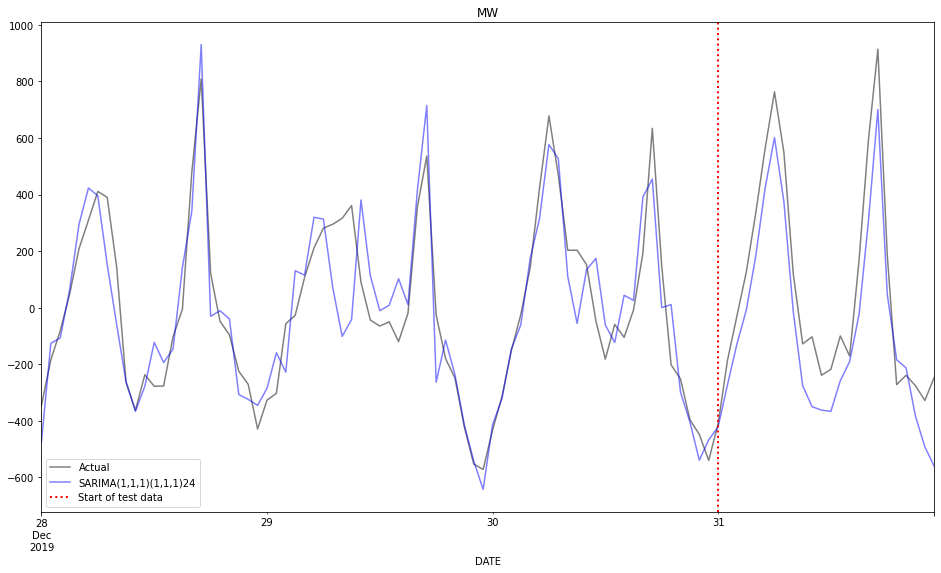

In [42]:
# Example forecast
fcst0 = df_ex.copy()

fcst0.iloc[-4*prediction_length:, 0].plot(label='Actual', c='k', alpha=0.5)
fcst0.iloc[-4*prediction_length:, 1].plot(label='SARIMA(1,1,1)(1,1,1)24', c='b', alpha=0.5)
plt.axvline(x=fcst0.index[-prediction_length], linestyle=':', linewidth=2, color='r', label='Start of test data')
plt.legend()
plt.title(mw);

In [44]:


results = load_df.iloc[-(prediction_length+context_length):].copy()

tic = time()
for i, col in enumerate(load_df.columns):
    if i % 10 == 0:
        toc = time()
        print("Running predictions for {}. Cumulative time: {:.1f} minutes.".format(col, (toc-tic)/60))
        
    # Prepare DataFrame for selected column
    load_dft = load_df.loc[:, col]
    
    # Find best model
    fcst, summary = runSARIMA(load_dft)
    # Add predictions to results DataFrame
    results['pred'] = fcst.values

toc = time()
print("Finished! Total run time: {:.1f} minutes.".format((toc-tic)/60))



Running predictions for MW. Cumulative time: 0.0 minutes.
Finished! Total run time: 0.1 minutes.


In [45]:


results0 = results.copy()
results0[results0 < 0] = 0
results0.head()



,MW,pred
DATE,,
2019-12-03 00:00:00,10847.0,11115.304997
2019-12-03 01:00:00,10679.0,11115.304997
2019-12-03 02:00:00,10628.0,11115.304997
2019-12-03 03:00:00,10729.0,10720.530729
2019-12-03 04:00:00,11178.0,10782.625782


In [47]:
sMASEs = []
for i, col in enumerate(load_df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred'].iloc[-prediction_length:]))

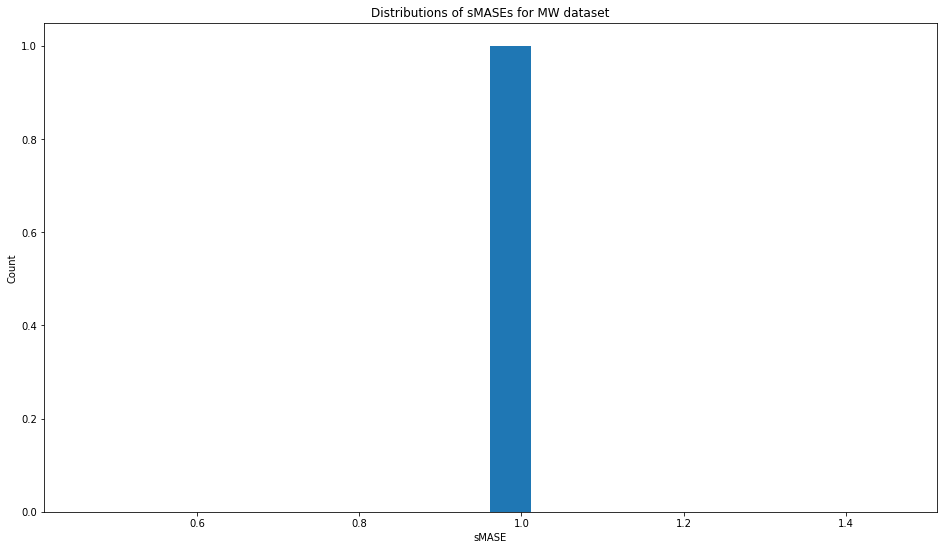

In [49]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format('MW'))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [50]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.9618


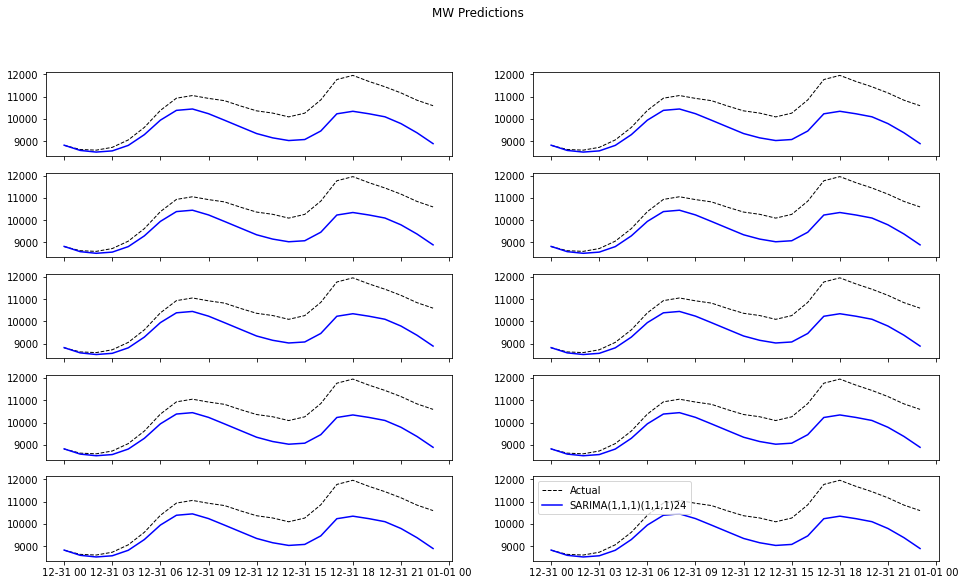

In [53]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results0.index[-prediction_length:], results0['MW'].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results0.index[-prediction_length:], results0['pred'].iloc[-prediction_length:],
                   label='SARIMA(1,1,1)(1,1,1)24', c='b')
ax[9].legend()
fig.suptitle('{} Predictions'.format('MW'));

In [57]:
results0['MAPE'] = (results0['MW'] - results0['pred']) / results0['MW']
print(results0)

                          MW          pred      MAPE
DATE                                                
2019-12-03 00:00:00  10847.0  11115.304997 -0.024735
2019-12-03 01:00:00  10679.0  11115.304997 -0.040856
2019-12-03 02:00:00  10628.0  11115.304997 -0.045851
2019-12-03 03:00:00  10729.0  10720.530729  0.000789
2019-12-03 04:00:00  11178.0  10782.625782  0.035371
...                      ...           ...       ...
2019-12-31 19:00:00  11682.0  10231.360191  0.124177
2019-12-31 20:00:00  11443.0  10094.968507  0.117804
2019-12-31 21:00:00  11167.0   9789.096639  0.123391
2019-12-31 22:00:00  10839.0   9376.183637  0.134959
2019-12-31 23:00:00  10593.0   8890.340434  0.160734

[696 rows x 3 columns]
